In [2]:
from numba import jit
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
from scipy.optimize import fmin

%matplotlib inline
# mpl.style.use('classic')
mpl.rc('figure', titlesize=30)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=15)
mpl.rc('figure', figsize=(15, 10))

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


# Metodo del simplesso per la minimizzazione di funzioni n-dimensionali

è richiesto di implementare l'algoritmo di Nelder-Mead del simplesso per minimizzare quattro funzioni in R2. 

## Algoritmo

I n dimensioni il simplesso è la regione di spazio delimitata da n+1 vertici. In 2 dimensioni il simplesso è un triangolo. Partendo da dei punti arbitrari nel dominio della funzione $x_1, x_2, x_3$, che definiscono il simplesso di partenza, è possibile fare muovere il simplesso verso la direzione del minimo della funzione. 

Non esistono teorie efficaci sulla scelta iniziale dei punti. Di conseguenza o vengono chiesti all'utente nel caso abbia idea di dove possa trovarsi. Tale punto è un "initial vertex guess" e da tale punto è possibile costruire il simplesso in maniera arbitraria. Un implementazione in matlab e nel pacchetto scipy di python costruisce il simplesso nella seguente maniera: fissato $x_1$ si calcolano gli altri i+1-esimi punti come

$$
x_{i+1} = x_1 + h(x_1, i)*u_i
$$

Dove $u_i$ sono i componenti della base canonica $h(x_1, i)$ è definita come:
* $h(x_1, i) = 0.05$ se la componente $u_i$ di $x_1$ è diversa da 0
* $h(x_1, i) = 0.00025$ se la componente $u_i$ di $x_1$ è 0

### Ordinamento
I tre punti iniziali $x_1, x_2, x_3$ sono valutati rispetto alla funzione di interesse$f$:$f(x_1), f(x_2), f(x_3)$. Tali punti vengono ordinati. Supponiamo che $f(x_1) \lt f(x_2) \lt f(x_3)$. In questo caso $f(x_1)$ rappresenta il punto migliore e $f(x_3)$ rappresenta il punto peggiore.

### Calcolo della baricentro
Viene calcolato il baricentro dei punti escluso quello peggiore. In questo caso viene calcolato il baricentro c come
$$
c = \frac{1}{2} (x_1 + x_2)
$$

### Trasformazione
Il simplesso viene trasformato a seconda della funzione:

#### Riflessione
Viene inizialmente provato questo tipo di trasformazione. Viene calcolato il punto di riflessione $x_r$ come
$$
x_r = c + \alpha (c - x_3)
$$
$\alpha$ è chiamato parametro di riflessione ed è un parametro scelto arbitrariamente. Solitamente si usa $\alpha = 1$ 

![Riflessione](img/simplesso1.png)

A seconda del valore $f(x_r)$ si eseguono gli step successivi. Se $f(x_1) \lt f(x_r) \lt f(x_2)$ cioè il punto riflesso è peggiore del punto 1 ma migliore del punto 2 si provvede a costruire il nuovo simplesso con $x_3 = x_r$

#### Espansione
Se $f(x_r) < f(x_1)$, cioè il punto trovato è migliore dell'attuale migliore, allora si esegue un ulteriore espansione del simplesso nella direzione. Si definisce quindi il punto di espansione $x_e$ come

$$
x_e = c + \gamma (x_r - c)
$$

![Espansione](img/simplesso2.png)


Dove $\gamma$ è un parametro di espansione arbitrario e in molte implementazioni vale 2.
Infine si cambia il punto $x_3$ con il migliore tra $x_r$ e $x_e$.

#### Contrazione
Se invece il punto riflesso è peggiore di $x_2$ allora probabilmente la direzione in cui si è mosso il simplesso non è quella ideale. Allora si procede ad una contrazione e il punto di contrazione $x_c$ viene definito come
$$
x_c = c + \beta (x_h - c)
$$

![Contrazione](img/simplesso3.png)

$\beta$ è un parametro di contrazione e tipicamente vale $\beta = 0.5$
Se $f(x_c) < f(x_3)$ allora $x_c$ prende il posto del vertice $x_3$. Altrimenti si passa all'ultima opzione che è quella di ridefinire il complesso

#### Ridefinizione del simplesso
In questo caso si tiene soltanto il punto migliore $x_1$ e si ridefiniscono gli altri j-esimi punti del complesso come:
$$
x_j^{new} = x_1 + \delta (x_j - x_1) \qquad j = 2, 3
$$

![Ridefinizione simplesso](img/simplesso4.png)


### Termine della procedura
La procedura può essere terminata in diversi modi. Ad esempio è possibile fermarsi quando:
* Un numero fissato di iterazioni è stato raggiunto
* Il simplesso raggiunge un valore minimo minore di un valore di soglia fissato

In [17]:
import numpy as np

def find_minimum(func, x1=None, N=50, params=np.array([1., 0.5, 2., 0.5])):
    alpha, beta, gamma, delta = params
    vfunc = np.vectorize(func)
    x2, x3 = np.zeros((2, 2))
    if x1 is None:  # costruzione simplesso iniziale
        x1 = np.array([1., 0])
    x2, x3 = construct_simplex(x1)
    simplex = np.array([x1, x2, x3])
    simplexes = simplex
    

    for i in range(N):
        simplexes = np.append(simplexes, simplex, axis=0)
        points = vfunc(simplex[:, 0], simplex[:, 1])
        osimplex = simplex[np.argsort(points)]  # ordered simplex
        c = centroid(osimplex)
        best, second, worst = osimplex
        xr = reflection(worst, c, alpha)
        fxr = func(*xr)
        if func(*best) < fxr < func(*second):  # caso 1: rimpiazzare xworst con xr
            simplex[np.where((simplex == worst).all(axis=1))] = xr
        elif fxr < func(*best):  # caso migliore: ulteriore espansione
            xe = expansion(xr, c, gamma)
            fxe = func(*xe)
            if fxe < fxr:  # scelta del miglior punto tra riflessione ed espansione
                simplex[np.where((simplex == best).all(axis=1))] = xe
            else:
                simplex[np.where((simplex == best).all(axis=1))] = xr
        elif fxr > func(*second): # caso peggiore: eseguire una contrazione
            xc = contraction(worst, c, beta)
            fxc = func(*xc)
            # se la contrazione è buona sostituire xworst con xv
            if fxc < func(*worst): 
                simplex[np.where((simplex == worst).all(axis=1))] = xc
            else:
                # ricostruisco il simplesso
                simplex = shrink_contraction(simplex, delta) 

    return best, func(*best), simplexes


def h(x, i):
    if x[i] == 0:
        return 0.00025

    return 0.05


def construct_simplex(x1):
    u1, u2 = np.array([
        [1, 0],
        [0, 1]
    ])
    x2 = x1 + h(x1, 0) * u1
    x3 = x1 + h(x1, 1) * u2

    return x2, x3


def centroid(simplex):
    c = 1 / 2. * np.sum(simplex[:-1, :].T, axis=1)

    return c


def reflection(x, c, alpha):
    return c + alpha * (c - x)


def expansion(x, c, gamma):
    return c + gamma * (x - c)


def contraction(x, c, beta):
    return c + beta * (x - c)


def shrink_contraction(simplex, delta):
    best, second, worst = simplex
    newsecond = best + delta * (second - best)
    newworst = best + delta * (worst - best)

    return np.array([best, newsecond, newworst])

In [18]:
# Funzioni da minimizzare

def booth(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

def booth2(xs):
    x, y = xs
    return booth(x, y)

def easom(x, y):
    return -np.cos(x)*np.cos(y)*np.exp(-((x - np.pi)**2 + (y-np.pi)**2))
    
def easom2(xs):
    x, y = xs
    return easom(x, y)

def goldstein(x, y):
    return np.exp(0.5*(x**2 + y**2 - 25)**2) \
            + np.power(np.sin(4*x - 3*y), 4) \
            + 0.5*(2*x + y - 10)**2

def goldstein2(xs):
    x, y = xs
    return goldstein(x, y)

def bukin(x, y):
    return 100*np.sqrt(np.abs(y - 0.01 * x**2)) + 0.01 * np.abs(x + 10)

def bukin2(xs):
    x, y = xs
    return bukin(x, y)

vbooth = np.vectorize(booth)
veasom = np.vectorize(easom)
vgoldstein = np.vectorize(goldstein)
vbukin = np.vectorize(bukin)

In [19]:
def plot_simplex(x, y, title, vfunc):
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    X, Y = np.meshgrid(x, y)
    z = vfunc(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)

    for i in range(int(simplexes[:, 1].size / 3) - 1):
        closedpoly = np.append(simplexes[i*3:i*3 + 3], simplexes[i*3]).reshape(4, 2)
        path = Path(closedpoly, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=1)
        ax.add_patch(patch)

    CS = plt.contour(X, Y, z, 30, cmap='jet')
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.clabel(CS, inline=1, fontsize=10)

Di seguito vengono confrontati i risultati di una libreria scipy utilizzata per la minimizzazione delle funzioni con il metodo del simplesso sopra implementato

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 74
         Function evaluations: 144
[1.00002936 2.99995593]

x = 3.062
y = 0.258
value = 1.362e+01



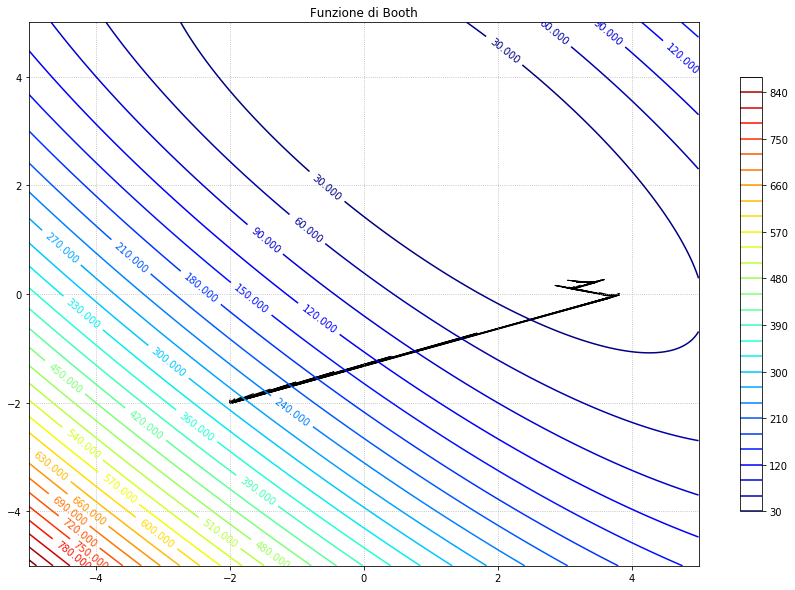

In [20]:
print(fmin(booth2, [1., 0]))
(x, y), value, simplexes = find_minimum(booth, [-2, -2])
print('''
x = {:.3f}
y = {:.3f}
value = {:.3e}
'''.format(x, y, value))
plot_simplex(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500), 
             'Funzione di Booth', vbooth)

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 36
         Function evaluations: 68
[3.14159912 3.14161248]

x = 3.181
y = 3.138
value = -9.976e-01



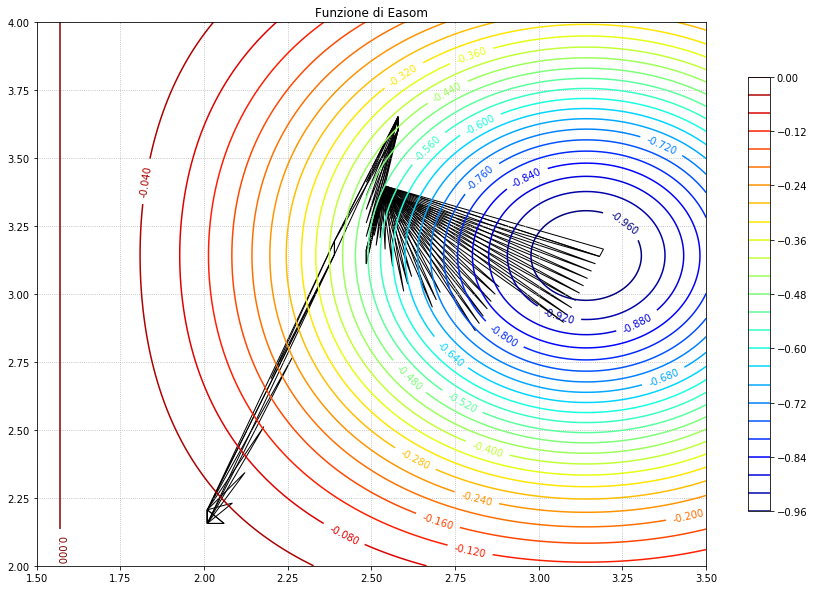

In [23]:
print(fmin(easom2, [2., 2]))
(x, y), value, simplexes = find_minimum(easom, [2.01, 2.15593])
print('''
x = {:.3f}
y = {:.3f}
value = {:.3e}
'''.format(x, y, value))
plot_simplex(np.linspace(1.5, 3.5, 500), np.linspace(2, 4, 500), 
             'Funzione di Easom', veasom)

In [29]:
bukin(-10.101, 1.579)

74.74711290844598

Optimization terminated successfully.
         Current function value: 0.030174
         Iterations: 64
         Function evaluations: 121
[-12.97056261   1.68235494]

x = -10.244
y = 1.049
value = 2.467e-02



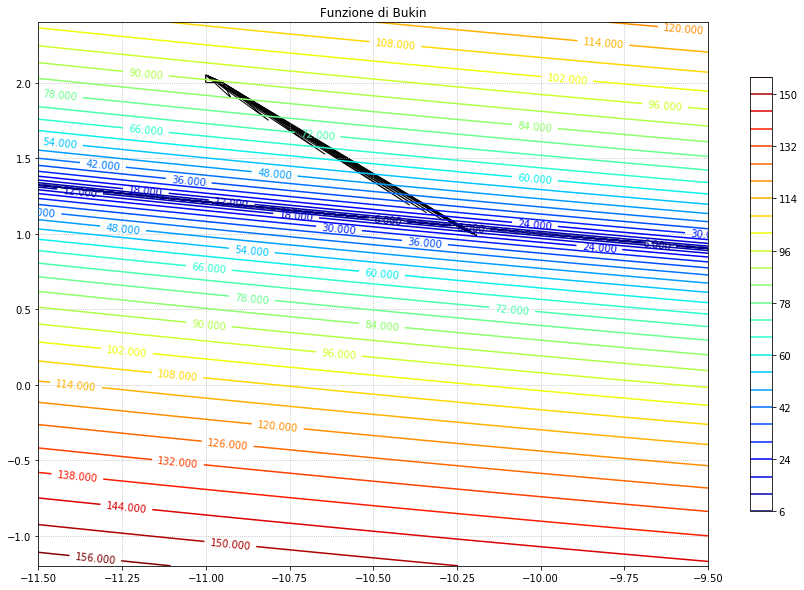

In [33]:
x0 = [-11, 2]
print(fmin(bukin2, x0))
(x, y), value, simplexes = find_minimum(bukin, x0)
print('''
x = {:.3f}
y = {:.3f}
value = {:.3e}
'''.format(x, y, value))
plot_simplex(np.linspace(-11.5, -9.5, 500), np.linspace(-1.2, 2.4, 500), 
             'Funzione di Bukin', vbukin)

Optimization terminated successfully.
         Current function value: 1.200429
         Iterations: 26
         Function evaluations: 53
[ 4.99253966 -0.53159414]

x = 4.993
y = -0.532
value = 1.200e+00



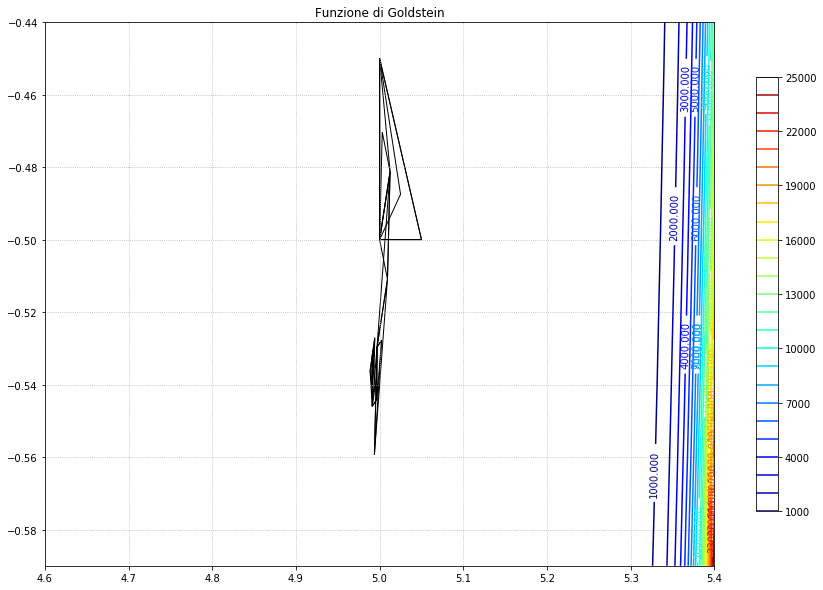

In [45]:
x0 = [5, -0.5]
print(fmin(goldstein2, x0))
(x, y), value, simplexes = find_minimum(goldstein, x0)
print('''
x = {:.3f}
y = {:.3f}
value = {:.3e}
'''.format(x, y, value))
plot_simplex(np.linspace(4.6, 5.4, 200), np.linspace(-0.59, -0.44, 200), 
             'Funzione di Goldstein', goldstein)